# Lab 8: Unsupervised Learning - Dimensionality Reduction

## A: [*Principal Component Analysis* ](#partA); B: [*Autoencoder*](#partB)

**Sources**:  This notebook was updated in 2024 by Dr Matthew Ellis but previous created by Dr Haiping Lu and is based on various sources. Part A is based on the [Dimensionality Reduction: Latent Variable Modelling notebook](https://nbviewer.jupyter.org/github/lawrennd/mlai2015/blob/master/week8.ipynb) by Neil Lawrence [MLAI2015]. Part B is based on the [Autoencoder notebook by Lisa Zhang from APS360, University of Toronto](https://www.cs.toronto.edu/~lczhang/aps360_20191/lec/w05/autoencoder.html) and Lab 2 of Dr Lu's [SimplyDeep](https://github.com/haipinglu/SimplyDeep/)  notebooks.


### Why unsupervised learning?
So far we have focused mainly on [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) problems including regression and classification, where training data samples are all labelled. Now we are going to turn to a different form of learning, commonly known as [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning). In unsupervised learning, our data are not labelled, but we want models that give us a better understanding of the data, which is called [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis) in some contexts. Unsupervised learning is a fundamental problem in machine learning and the focus is to learn from unlabelled data. Unsupervised feature learning or representation learning can find wide usage in various applications for extracting useful information from often abundant unlabelled data.

# <a id='partA'></a>A: Principal Component Analysis (PCA)








## A1: The PCA algorithm

PCA is a method by which we want to transform our data so as to select directions with maximal variance (or more completely ordering directions from highest to lowest variance). In this example we will work on the popular [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) of handwritten digits for easy visualisation. By finding directions that maximise the variance, when we perform dimensionality reduction by removing dimensions in this transformed representation then we be keeping as much information as possible. 

PCA is a linear transformation of the data using the eigenvectors of the covariance matrix. This transformation is
$$ \mathbf{y} = \mathbf{U}^T \mathbf{x} $$
for $d$-dimensional datapoint vector $\mathbf{x}$ and transformation matrix $\mathbf{U}$. This transformation matrix is formed as
$$ \mathbf{U} = \begin{pmatrix} \mathbf{u}_1, \mathbf{u}_2, \cdots \mathbf{u}_m \end{pmatrix} $$
where $ m \le d$ is the number of dimensions kept in the transformation space. The vectors $\mathbf{u}_i$ are the eigenvectors of the correlation matrix with  $\mathbf{u}_1$ known as the 1st principal component (the eigenvector corresponding to the greatest eigenvalue).

To reconstruct the datapoint, we need to multiply each eigenvector by it's value in the transformed space and add the mean we subtracted
$$ \tilde{\mathbf{x}} = \mathbb{E}[\mathbf{x}] + \mathbf{U} \mathbf{y} $$
this is equivalent to
$$ \tilde{\mathbf{x}} =  \mathbb{E}[\mathbf{x}] + \mathbf{u}_1 y_1 + \mathbf{u}_2 y_2 + \cdots + \mathbf{u}_m y_m $$

The algorithm for PCA is:
1) Calculate and subtract the mean of the data. Keep the mean for later reconstruction.
2) Calculate the covariance matrix of the data.
3) Find the eigenvectors and eigenvalues of the covariance matrix.
4) Order the eigenvectors by the eigenvalues.
5) Create the transformation matrix from the desired number of eigenvectors.
6) To calculate the transformed datapoint $\mathbf{y}$ we matrix multiply $\mathbf{x}$ with the transposed matrix $\mathbf{U}$.



The following cells will download the MNIST data from PyTorch and apply this transformation.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Use PyTorch to download the data
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

# For simplicity we will take just the first 10k samples 
mnist_dl = DataLoader(mnist_data, batch_size=10000)

x_train, train_labels = map( torch.Tensor.numpy, next(iter(mnist_dl)))

image_dim = x_train.shape[-2:]
N_pixels = np.prod(image_dim)


In [6]:
def preprocess(datapoints, spherise = False):
    '''
    Function that calculates and subtracts the mean of the datapoints.
    Spherise will divide each datapoint by it's vector magnitude.
    '''
    mean = np.mean(datapoints, axis = 0)
    z = datapoints - mean
    if spherise:
        for i in range(len(z)):
            z[i] = z[i] / np.sqrt(np.sum(np.square(z)))
    
    return z, mean

In [5]:
# Preprocess: Subtract the mean from the datapoints but keep the mean for reconstruction
z_train, x_mean = preprocess(x_train)

# Flatten the images into a 1d vector per sample
z_train = z_train.reshape((-1, N_pixels))

# Calculate the correlation matrix
# With z_train = (N_samples by N_features) if we perform a matrix multiplication
# where we sum over the N_samples dimensions then we will calculate sum_i (x_ij - mean_j)(x_ik - mean_k)
# which is the definition of the covariance matrix
N_samples = len(z_train)
C = z_train.T @ z_train / N_samples

Let's plot the covariance matrix now to see if any features stand out.

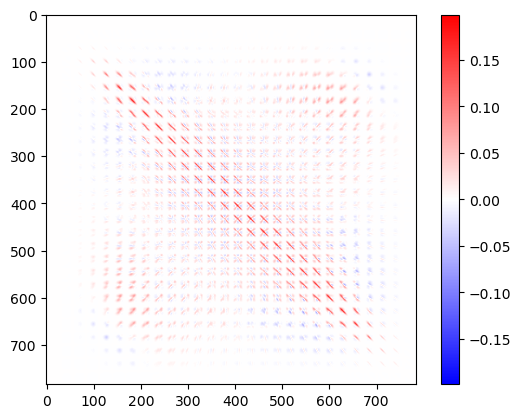

In [7]:
plt.imshow(C, cmap='bwr')
plt.clim([-np.max(C), np.max(C)])
plt.colorbar()
plt.show()

#### Question 1
---

What patterns can you see in the covariance matrix? Can you explain what gives rise to some of them?

---



Write your answer here.



Now we have the covariance matrix, we can calculate the eigenvectors and values. To do this we can use the `eigh()` function from `np.linalg`. We could also use the `eig()` function but we can exploit some properties of the covariance matrix here. Let's print the docstring for `eigh()` to see why. 

In [8]:
help(np.linalg.eigh)

Help on function eigh in module numpy.linalg:

eigh(a, UPLO='L')
    Return the eigenvalues and eigenvectors of a complex Hermitian
    (conjugate symmetric) or a real symmetric matrix.
    
    Returns two objects, a 1-D array containing the eigenvalues of `a`, and
    a 2-D square array or matrix (depending on the input type) of the
    corresponding eigenvectors (in columns).
    
    Parameters
    ----------
    a : (..., M, M) array
        Hermitian or real symmetric matrices whose eigenvalues and
        eigenvectors are to be computed.
    UPLO : {'L', 'U'}, optional
        Specifies whether the calculation is done with the lower triangular
        part of `a` ('L', default) or the upper triangular part ('U').
        Irrespective of this value only the real parts of the diagonal will
        be considered in the computation to preserve the notion of a Hermitian
        matrix. It therefore follows that the imaginary part of the diagonal
        will always be treated as zero

So it is used for a 'real symmetric matrix' matrix. Can you prove why that is the case for the covariance matrix?

In [7]:
# Compute the eigenvalues and eigenvectors
l, U = np.linalg.eigh(C)

# eigh gives us the eigenvalues in ascending order
# Here we can reverse this
l = l[::-1]
U = U[:, ::-1]

In [8]:

# u is a matrix with each eigenvector in columns.
# To transform our data we multiply the transpose of this with our datapoints.
# Since z has samples as the first dimension we would need to transpose it first.
# This would give y as samles on the second dimensions so we might transpose back 
# Instead we can then transpose the right hand side
# i.e  y = U^T z   so   y^T = (U^T z)^T = z^T U  meaning a row in our matrix
# Remember z is x - mean
y = z_train @ U

We have now transformed our data. Let's plot the first two dimensions (i.e the first 2 principal components) to visualise the MNIST data.

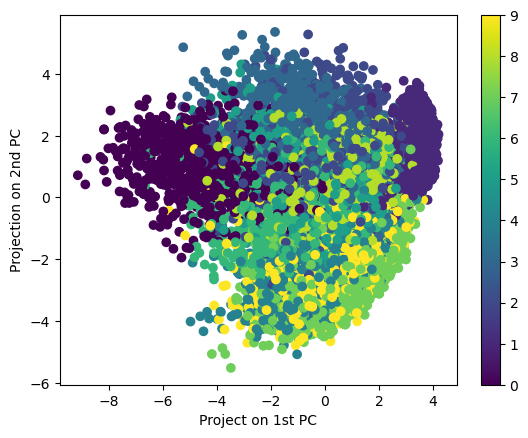

In [9]:
# Plot the data for the first and second principal components.
#  We will colour the points using the class labels.

plt.scatter(y[:,0], y[:,1], c = train_labels)
plt.xlabel('Project on 1st PC')
plt.ylabel('Projection on 2nd PC')
plt.colorbar()
plt.show()


You can see for the MNIST it has provided a fairly good representation of a few of the classes but not all.

### Explained Variance

To measure how much of the original variance is stored in the principal components we can calculate the fraction of explained variance.
This is sum of the eigenvalues in our reduced dimension space divided by the sum of all the eigenvalues. This is written as 
$$ EV(m) = \frac{\sum_i^{m} \lambda_i}{\sum_j^{d} \lambda_j} $$
where $\lambda_i$ are the eigenvalues of the correlation matrix, $m$ is the size of the transformed space (i.e number of PC's kept when performing DR) and $d$ is the original datapoint size. 

#### Question 2
---
Calculate the explained variance for $m=1$ to $d$ and plot it against $m$. How many dimensions do you need to keep at least 80\% of the original variance.


You can see for the MNIST it has provided a fairly good representation of a few of the classes but not all.

### Explained Variance

To measure how much of the original variance is stored in the principal components we can calculate the fraction of explained variance.
This is sum of the eigenvalues in our reduced dimension space divided by the sum of all the eigenvalues. This is written as 
$$ EV(m) = \frac{\sum_i^{m} \lambda_i}{\sum_j^{d} \lambda_j} $$
where $\lambda_i$ are the eigenvalues of the correlation matrix, $m$ is the size of the transformed space (i.e number of PC's kept when performing DR) and $d$ is the original datapoint size. 

#### Question 2
---
Calculate the explained variance for $m=1$ to $d$ and plot it against $m$. How many dimensions do you need to keep at least 80\% of the original variance.



In [23]:
#Code your answer here. You might want to use np.cumsum() to do a cumulative sum.

	#\lambda_i: Eigenvalues of the correlation or covariance matrix.
	#	Each eigenvalue represents the variance explained by a corresponding principal component.
	#	m: Number of principal components in the reduced space.
	#	d: Total number of dimensions in the original dataset.
	#	The numerator \sum_{i=1}^{m} \lambda_i sums the variances explained by the first m principal components.
	#	The denominator \sum_{j=1}^{d} \lambda_j is the total variance of the dataset.

# Total variance
total_variance = np.sum(l)
print(total_variance)

# Calculate cumulative explained variance and then we find l that stop at 80%
explained_variance = np.cumsum(l[:40]) / total_variance
print(explained_variance)



52.752155
[0.10200027 0.17415465 0.23526222 0.28941855 0.33717984 0.38131574
 0.4141432  0.44341522 0.4712622  0.49433568 0.5156309  0.5361746
 0.55304444 0.56986254 0.5860298  0.6014155  0.6142945  0.62693185
 0.6385223  0.6497997  0.66013885 0.67021704 0.67966187 0.6888965
 0.6974456  0.7058762  0.7139127  0.7216694  0.728873   0.7357269
 0.7422581  0.7485523  0.7545019  0.7603792  0.7658996  0.771193
 0.7763271  0.78112435 0.78588283 0.790559  ]


**Reconstruction**

Now we can see how well PCA does at reconstructing the original images using only the first few principal components.
Remember the reconstructed datapoint is
$$ \tilde{\mathbf{x}} =  \mathbb{E}[\mathbf{x}] + \mathbf{u}_1 y_1 + \mathbf{u}_2 y_2 + \cdots + \mathbf{u}_m y_m $$
for transformed vector $\mathbf{y}$.

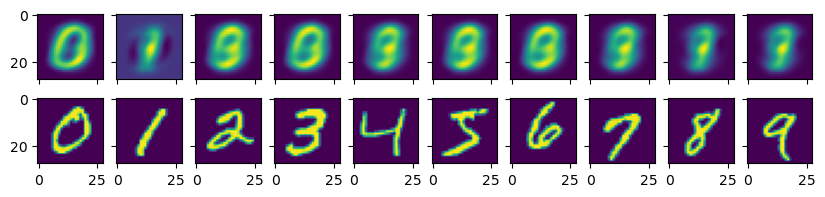

In [11]:
# Reconstruct from only the 1st PC
def reconstruct(y, U, mean):
    y1 = y[0]
    u1 = U[:,0]
    return mean + y1*u1

# Use np.unique to find the first instance of each class
counts, ids = np.unique(train_labels, return_index=True)

# Below we will plot the reconstruction against the original image
fig, axs = plt.subplots(2, 10, sharex=True, sharey=True)
fig.set_size_inches(10, 2)

for i in range(len(ids)):
    x_tilde = reconstruct(y[ids[i]], U, x_mean.flatten())
    axs[0,i].imshow(x_tilde.reshape((28,28)))
    axs[1,i].imshow(x_train[ids[i],0])
plt.show()

We can see that the reconstruction using only the 1st PC is not very good. Not surprising really but can you spot some classes which are better? Look back at the 2d plot and can you relate the classes that do well to where the classes lie in this plot?

#### Question 3

---
Adapt the code in the previous cell to use more PCs during the reconstruction. Start with 2 PCs then increase it in powers of 2. How does the performance compare to the explained variance plot above?  Try to simplify the reconstruction using matrix operations if you can.


### PCA using Scikit-learn

In practice we will use a library version of PCA. This section demonstrates using the version available in Scikit-learn. The Scikit-learn PCA class will fit and perform the transformation for us. Whilst there are a few parameters, the most important is `n_components` which is the number of principal components that will be kept in the transformed space.

In [12]:
from sklearn.decomposition import PCA

# create a PCA class with 4 components
pca = PCA(n_components=4)

# Reshape the data for the fit function
x_train = x_train.reshape((-1, N_pixels))

# fit the PCA class to our training data.
pca.fit(x_train)

PCA(n_components=4)

Now that we have fitted our PCA transformation (internally this has built the transformation matrix $\mathbf{U}$) we can check to see how much of the original data variance if explained by each component.

In [13]:
print("Fraction of variance in each component:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum() )

Fraction of variance in each component: [0.10199993 0.07215449 0.06110754 0.05415631]
Total explained variance: 0.28941828


Remember these are eigenvalues normalised to the sum of the eigenvalues. The first component explains about 10% of the variance and in total the first 4 components explains about 29%. We might expect that this will be a poor transformation of our data.

Let's try transforming our faces, then transforming back to give reconstruced images. 

In [14]:
transformed_data = pca.transform(x_train)

reconstructed_data = pca.inverse_transform(transformed_data)

# Quantify how close our reconstruction is
from sklearn.metrics import mean_squared_error
reconstruction_error = mean_squared_error(x_train, reconstructed_data)
print('Reconstruction error is ', reconstruction_error)

Reconstruction error is  0.047812097


The reconstruction error looks rather small (should be around 0.0478) but it is hard to know whether this is a good value or not without a reference. Let's consider the result if we replace each image with it's mean value (a bit like having no components). 

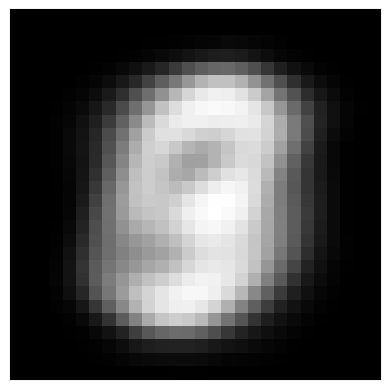

Reconstruction error is  0.06728599
So PCA(4) is an improved by  1.4073006


In [16]:
mean_data = x_train.mean(axis=0)
plt.imshow(mean_data.reshape(28,28), cmap='Greys_r')
plt.xticks([])
plt.yticks([])
plt.show()

data_as_mean = np.repeat(mean_data.reshape(1,-1), len(x_train), axis=0)
reconstruction_as_mean_error = mean_squared_error(x_train, data_as_mean)
print('Reconstruction error is ', reconstruction_as_mean_error)
print('So PCA(4) is an improved by ', reconstruction_as_mean_error/reconstruction_error)

Compared to the mean face, PCA has reduced the error by a factor of 1.4 so it does help a little keeping 4 components. 
Let's plot some of the reconstructed images to see how well it has performed visually.

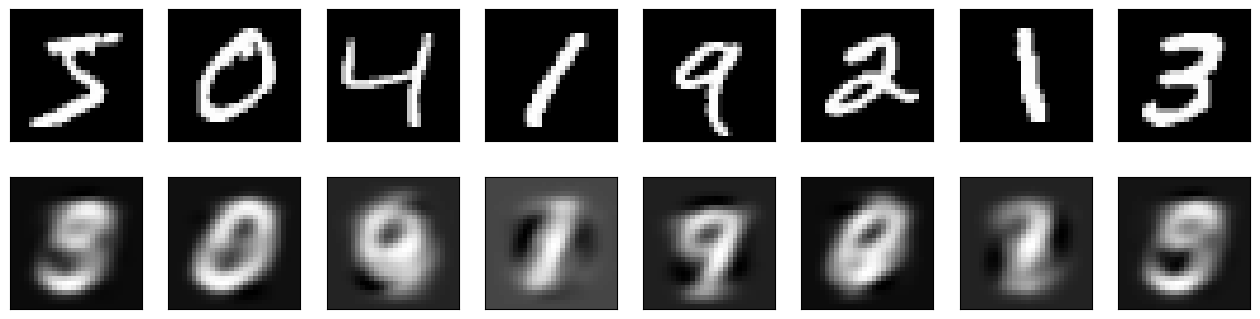

In [17]:
plt.figure(figsize=(16, 4))
for i in range(8):
    # Top row: show original data
    plt.subplot(2,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='Greys_r')
    # Bottom row: show reconstructions
    plt.subplot(2,8, 8+i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(reconstructed_data[i].reshape(28,28), cmap='Greys_r')
plt.show()

Most of the images have not been reconstructed well, in fact most are close to the mean face and a lot of details are lost. It appears as if we need to use more components in our transformation.

#### Question 4
---

Go back to your earlier plot of the explained variance. Choose the number of components that will keep at least 80\% of the explained variance. Now train the scikit-learn PCA class on this number of components and repeat the calculation of the reconstruction error. How much has it improved it vs 4 components? Are the plots better again.


In [ ]:
# write your code here.

### Further exercises
Run the Scikit-learn example [Face recognition example using eigenfaces and SVMs](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html). More examples on PCA are at the bottom of the [PCA documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

# <a id='partB'></a>B: Autoencoder with PyTorch

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

#Set the random seed for reproducibility 
torch.manual_seed(2020) 

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
print(len(mnist_data))

# Take out only the first 10000 samples
mnist_data = list(mnist_data)[:10000]
print(len(mnist_data))

# I don't recommend splitting the dataset in this manner normally, using list().
# You should consider using the PyTorch random_split here:
# https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

#### Autoencoder architecture

An autoencoder is a neural network model trained to first **encode** an input into a reduced representation (a 'code' or latent space) before reconstructing it using a **decoder**. If the model can correctly encode then decode the output should be the same as the input, hence the 'auto' part of the name. These are two separate processes but they can both be defined as feed forward neural networks. It's common to have the decoder mirroring the encoder but it's important that the internal (hidden) representation is reducing.

<img src="https://miro.medium.com/max/3148/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png" style="height:5cm;"/>

Let's define our auto-encoder model. To start with let's consider model with two linear layers: one to encode the image, one to decode it.

---
#### Question 5 

Adapt the code below to define an Auto-Encoder using a single fully connected (`nn.Linear`) both the encoder and decoder (so two layers overall). Define the hidden layer to have 30 neurons (this means 30 dimensions in your latent 'code' space).

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = 
        self.decoder = 

    def forward(self, x):

        # x will be a (batch_size,1,28,28) tensor when using MNIST
        # so we will reshape it to a (batch_size, 28*28) flat tensor.
        # After it has been decoded we will reshape back to the image shape.
        
        z = self.encoder(x.view(-1, 784))
        x = self.decoder(z)
        return x.view(-1, 1, 28, 28)

Again, `__init__()` defines the layers and we can define internal classes to contain the encoder and decoder networks separately. When you want to use more complex networks for these you can use `nn.sequential` or a `nn.Module` to define an object that will contain all the operations for each part of the auto-encoder.  `forward()` defines the *forward pass* that first transforms the input into the latent represetnation using the encoder, then the decoder is used to reconstruct the image from the code. `backward()` is automatically defined using `autograd`. Since the encoder and decoder are contained within the class, if they are defined as PyTorch models then it will be possible to use each part indepently using `model.encoder(x)` or `model.decoder(z)` where `x` and `z` are an input image or latent code representation resepctively.

Note: When you consider deeper network versions you may want to use `ReLu()` and `Sigmoid()` are [rectified linear unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) and [Sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), two popular **activation function** that performs a *non-linear* transformation/mapping of an input variable (element-wise operation).



#### Inspect the NN architecture

Now let's create and instance of the model and take a look at the autoencoder structure.

In [ ]:
myAE=Autoencoder()
print(myAE)

Let us check the (randomly initialised) parameters of this NN. If you have defined two Linear layers to make up the auto-encoder then this will be the weights and biases of these layers.

In [ ]:
params = list(myAE.parameters())
print(len(params))
print(params[0].size())  # First Linear's .weight
print(params[1].size())  # First Linear's .bias
print(params[1])

#### Train the NN
Next, we will feed data in this autoencoder to train it, i.e., learn its parameters so that the reconstruction error (the `loss`) is minimised, using the mean square error (MSE) and `Adam` optimiser. The dataset is loaded in batches to train the model. One `epoch` means one cycle through the full training dataset. The `outputs` at the end of each epoch save the orignal image and the reconstructed (decoded) image pairs for later inspection. Again, the steps are 
* Define the optimisation criteria and optimisation method.
* Iterate through the whole dataset in batches, for a number of `epochs` till a maximum specified or a convergence criteria (e.g., successive change of loss < 0.000001)
* In each batch processing, we 
    * do a forward pass
    * compute the loss
    * backpropagate the loss via `autograd`
    * update the parameters


For the Auto-Encoder our goal is to train the network such that the reconstructed output (output of the model) is as close as possible to the original input. For this task we can use the `reconstruction error` as the loss for this task. The reconstruction error is the mean squared distance between the reconstructed output and the original input defined as
$$ E = \frac{1}{N} \sum_{n=1}^N (\mathbf{x} - \tilde{\mathbf{x}})^2 $$
where $\mathbf{x}$ is the vector of the original image and $\tilde{\mathbf{x}}$ is the output of the model, which should have matching shapes. 

---

#### Question 6

The starting point for the training code is given below. As before, you will have to complete the training routines. Think about how you need to calculate the loss, in this case you do not need to use the labels.

In [ ]:
def train_AE(model, dataset, max_epochs=20, print_steps=5):
    #Training (optimisation) parameters
    batch_size=64
    learning_rate=1e-3

    #Choose mean square error loss
    criterion = nn.MSELoss() 

    #Choose the Adam optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    #Specify how the data will be loaded in batches (with random shuffling)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    #Storage
    outputs = []

    #Start training
    for epoch in range(max_epochs):
        for img, label in train_loader:

            # Calculate the reconstructed image after passing through the AE
            recon = model(img)

            # Calculate the reconstruction error
            # This is the mean squared error but which arguments do you pass to the function?
            loss = 

            # You will need to include the remaining parts of the training routine
          
        # Print out the loss every few iterations
        if ((epoch % print_steps) == 0) or (epoch +1 == max_epochs):
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss.item()))
        
        # We will store the input image and reconstructed image 
        outputs.append((epoch, img.detach(), recon.detach()),)

    return outputs



In [ ]:
outputs = train_AE(myAE, mnist_data, max_epochs=50)

Hopefully you will see that the loss is reducing. In my case it reached a value around 0.016 in 50 epochs.

We can inspect the reconstructed images at different epochs below. Note here we use `.detach()` because the gradients are not needed for inspection purpose here. 

In [ ]:
numImgs=12
for k in range(0, len(outputs), 10):
    plt.figure(figsize=(numImgs, 2))
    imgs = outputs[k][1].numpy()    
    recon = outputs[k][2].numpy()
    print('Epoch:', k+1)
    for i, item in enumerate(imgs):
        if i >= numImgs: break
        plt.subplot(2, numImgs, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= numImgs: break
        plt.subplot(2, numImgs, numImgs+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
    plt.show()

For a comparison let's compare our auto-encoder to PCA. They are similar but our auto-encoder has a non-linear activation function while PCA does not. Let's compute the mean squared error to compare to the loss above (they should be the same metric).

In [ ]:
from sklearn.decomposition import PCA

# create a PCA class with 30 components
pca = PCA(n_components=30)

# Create a dataloader to pass all the training data
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=len(mnist_data))
images, labels = next(iter(train_loader))

transformed_images = pca.fit_transform(images.numpy().reshape(-1,28*28))
reconstructed_images = pca.inverse_transform(transformed_images)

from sklearn.metrics import mean_squared_error
reconstruction_error = mean_squared_error(images.numpy().reshape(-1,28*28), reconstructed_images)
print('Reconstruction error is ', reconstruction_error)


So PCA is performing slightly worse than the auto-encoder but both has similar architectures and optimisation criteria. 

#### Question 7
Try increasing the size of your encoder and decoder networks. Does the performance improve? Try visualising the reconstruction with a smaller size in your latent 'code' space, how does this affect the reconstruction?

In [ ]:
# Try a different architecture here.

## Improving the auto-encoder architecture

#### Question 8

Currently our auto-encoder uses linear layers but we have already discussed how convolutional layers can be better when applied to images. Let's modify the definition of the auto-encoder to use them. We want an auto-encoder with 3 convolutional layers in both the encoder and decoder. 
The first layer is defined for you but you need to complete the definition so that it has the following structure:


**Encoder**
- Conv2d: **1** input channel, **16** output channels, 3x3 square convolution, stride 2, pad 1. (already coded)
- ReLU activation function
- Conv2d: **16** input channel, **32** output channels, 3x3 square convolution, stride 2, pad 1.
- ReLU activation function
- Conv2d: **32** input channel, **64** output channels, 7x7 square convolution, stride 1, pad 0.

**Decoder**
- ConvTranspose2d: **64** input channel, **32** output channels, 7x7 square convolution, stride 1.
- ReLU activation function
- ConvTranspose2d: **32** input channel, **16** output channels, 3x3 square convolution, stride 2, pad1, output pad 1.
- ReLU activation function
- ConvTranspose2d: **16** input channel, **1** output channels, 3x3 square convolution, stride 2, pad 1, output pad 1. (already coded)
- Sigmoid activation function (already coded)

The sigmoid activation function at the end returns our output in the range $[0,1]$ which is what is expected for the pixel intensity.

Also, can you determine what size is the encoded image?

Note: If you don't program the other layers and run the model you might find that you get better performance. Why do you think this is? 
Remember the goal of the auto-encoder is to find a reduced dimensionality.

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            # activation function
            # conv layer
            # activation function 
            # conv layer
        )
        self.decoder = nn.Sequential(
            # conv transpose layer
            # activation function
            # conv transpose layer
            # activation function
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Here, we have both convolution layers `Conv2d()` and transpose convolution layers `ConvTranspose2d()`, with nice illustrations at [Convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic). The basic ones are reproduced below where blue maps indicate inputs, and cyan maps indicate outputs.


**Convolution with no padding, no stride**

![Convolution](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)

**Transpose convolution with no padding, no strides**

![Transposed convolution](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides_transposed.gif)


In [ ]:
myCAE = ConvAutoencoder()
print(myCAE)

In [ ]:
outputs = train_AE(myCAE, mnist_data, max_epochs=30, print_steps=5)

Your convolutional auto-encoder should reach a lower loss than before (approximately 0.0012). Let's check out some of the resulting images as well.

In [ ]:
numImgs=12
for k in range(0, len(outputs), 10):
    plt.figure(figsize=(numImgs, 2))
    imgs = outputs[k][1].numpy()    
    recon = outputs[k][2].numpy()
    print('Epoch:', k+1)
    for i, item in enumerate(imgs):
        if i >= numImgs: break
        plt.subplot(2, numImgs, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= numImgs: break
        plt.subplot(2, numImgs, numImgs+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
    plt.show()

Hopefully your convolutional auto-encoder has done a better job at reconstructing the images.

#### Generate synthesised images
We can **interpolate** between two images via the learned embeddding. Let us pick the first `5` (on my machine) and fifth image `9`  (on my machine) from the first epoch and obtain the low-dimensional embedding using the learned encoder. 

In [ ]:
img1Index=0
img2Index=4

x1, label1 = mnist_data[img1Index] # first image
x2, label2 = mnist_data[img2Index] # second image

x = torch.stack([x1,x2])     # stack them together so we only call `encoder` once

embedding = myCAE.encoder(x)
e1 = embedding[0] # embedding of first image
e2 = embedding[1] # embedding of second image
print(e1.size())

In [ ]:
embedding.size()

In the embedding space, we do a linear interpolation between the two embeddings and then decode these interpolated embeddings into images.

If we have two embedding codes given by tensors $\mathbf{e}_1$ and $\mathbf{e}_2$ we can generate an embedding that lies between them by using
$$ \mathbf{e} = (1- a) \mathbf{e}_1 + a \mathbf{e}_2 $$
where $a$ is the fraction of $\mathbf{e}_2$ in the generated tensor.

In [ ]:
embedding_values = []
for a in np.linspace(0, 1, 11):
    e = e1 * (1-a) + e2 * a
    embedding_values.append(e)
embedding_values = torch.stack(embedding_values)

recons = myCAE.decoder(embedding_values)

plt.figure(figsize=(11, 2))
for i, recon in enumerate(recons.detach().numpy()):
    plt.subplot(2,11,i+1)
    plt.imshow(recon[0])
    plt.yticks([])
    plt.xticks([])
    

plt.subplot(2,11,12)
plt.imshow(x1.reshape((28,28)))
plt.yticks([])
plt.xticks([])

plt.subplot(2,11,22)
plt.imshow(x2.reshape((28,28)))
plt.yticks([])
plt.xticks([])

Have a go at selecting different embedding starting points using `e1` and `e2` to move between different labels.

---
**Question 4**

Define and train an auto-encoder that has a 'code' size of 2 (i.e after applying the encoder each image should be compressed to just 2 values). It will be easier to modify the auto-encoder with linear layers but if you feel adventurous you can try the convolutional auto-encoder. 

After you have trained it, use your auto-encoder to transform the training data and make a scatter plot of the transformed data. Colour the scatter points by the label. How well are the images of a given label grouped together?

---

## Additional ideas to explore

* Code PCA using ``torch.nn`` and compare it with the close-form solution via eigendecomposition (e.g. that in `sklearn`).
* Try out different optimisers or different loss function (the L1loss, MAE) and compare the results.
* Change the architecture of autoencoder (e.g., depth, other layers such as max pooling, different activation functions) to compare the results.
* Repeat the above on a subset from the CIFAR10 dataset. For example, you can interpolate a cat and a dog.